# 12. NATURAL LANGUAGE PROCESSING

# 12.3. Word Vectors

# 12.3.1. COURS

# Word Embeddings

In [1]:
import numpy as np
import spacy

# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

C:\Users\Outils\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# Disabling other pipes because we don't need them and it'll speed up this part a bit
text = "These vectors can be used as features for machine learning models."
with nlp.disable_pipes():
    vectors = np.array([token.vector for token in  nlp(text)])

In [3]:
vectors.shape

(12, 300)

In [4]:
import pandas as pd

# Loading the spam data
# ham is the label for non-spam messages
spam = pd.read_csv('input/spam.csv')

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in spam.text])
    
doc_vectors.shape

(5572, 300)

# Classification Models

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, spam.label,
                                                    test_size=0.1, random_state=1)

In [6]:
from sklearn.svm import LinearSVC

# Set dual=False to speed up training, and it's not needed
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )

Accuracy: 97.133%


# Document Similarity

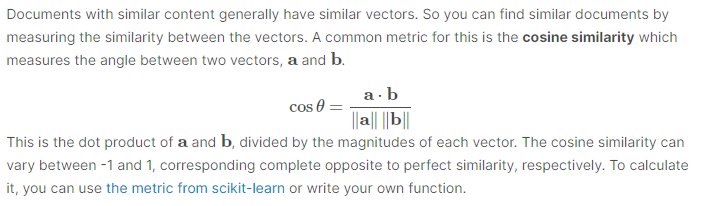

In [7]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

In [8]:
a = nlp("REPLY NOW FOR FREE TEA").vector
b = nlp("According to legend, Emperor Shen Nung discovered tea when leaves from a wild tree blew into his pot of boiling water.").vector
cosine_similarity(a, b)

0.7030031

# 12.3.2. EXERCICES

# Vectorizing Language

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

In [10]:
# Load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

review_data = pd.read_csv('input/yelp_ratings.csv')
review_data.head()

C:\Users\Outils\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,5.0,1
2,I have to say that this office really has it t...,5.0,1
3,Went in for a lunch. Steak sandwich was delici...,5.0,1
4,Today was my second out of three sessions I ha...,1.0,0


In [11]:
reviews = review_data[:100]
# We just want the vectors so we can turn off other models in the pipeline
with nlp.disable_pipes():
    vectors = np.array([nlp(review.text).vector for idx, review in reviews.iterrows()])
    
vectors.shape

(100, 300)

In [13]:
# Loading all document vectors from file
vectors = np.load('input/review_vectors.npy')

# 1) Training a Model on Document Vectors

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectors, review_data.sentiment, 
                                                    test_size=0.1, random_state=1)

# Create the LinearSVC model
model = LinearSVC(random_state=1, dual=False)
# Fit the model
model.fit(X_train, y_train)

# Uncomment and run to see model accuracy
print(f'Model test accuracy: {model.score(X_test, y_test)*100:.3f}%')


Model test accuracy: 93.847%


In [15]:
# Scratch space in case you want to experiment with other models
from sklearn.linear_model import LogisticRegression

second_model = LogisticRegression(penalty='none',solver='newton-cg')
second_model.fit(X_train, y_train)
print(f'Model test accuracy: {second_model.score(X_test, y_test)*100:.3f}%')

Model test accuracy: 93.914%


C:\Users\Outils\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Outils\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


# 3) Find the most similar review

In [16]:
review = """I absolutely love this place. The 360 degree glass windows with the 
Yerba buena garden view, tea pots all around and the smell of fresh tea everywhere 
transports you to what feels like a different zen zone within the city. I know 
the price is slightly more compared to the normal American size, however the food 
is very wholesome, the tea selection is incredible and I know service can be hit 
or miss often but it was on point during our most recent visit. Definitely recommend!

I would especially recommend the butternut squash gyoza."""

def cosine_similarity(a, b):
    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))

review_vec = nlp(review).vector

## Center the document vectors
# Calculate the mean for the document vectors, should have shape (300,)
vec_mean = vectors.mean(axis=0)
# Subtract the mean from the vectors
centered = vectors - vec_mean

# Calculate similarities for each document in the dataset
# Make sure to subtract the mean from the review vector
sims = np.array([cosine_similarity(review_vec - vec_mean, vec) for vec in centered])

# Get the index for the most similar document
most_similar = sims.argmax()

In [17]:
print(review_data.iloc[most_similar].text)

After purchasing my final christmas gifts at the Urban Tea Merchant in Vancouver, I was surprised to hear about Teopia at the new outdoor mall at Don Mills and Lawrence when I went back home to Toronto for Christmas.
Across from the outdoor skating rink and perfect to sit by the ledge to people watch, the location was prime for tea connesieurs... or people who are just freezing cold in need of a drinK!
Like any gourmet tea shop, there were large tins of tea leaves on the walls, and although the tea menu seemed interesting enough, you can get any specialty tea as your drink. We didn't know what to get... so the lady suggested the Goji Berries... it smelled so succulent and juicy... instantly SOLD! I got it into a tea latte and watched the tea steep while the milk was steamed, and surprisingly, with the click of a button, all the water from the tea can be instantly drained into the cup (see photo).. very fascinating!

The tea was aromatic and tasty, not over powering. The price was also 